# Imports

In [1]:
import os
import json
import random
from collections import * 
import imageio
import pickle
import multiprocessing
from operator import itemgetter

from tqdm import tqdm_notebook, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV

import h5py
import cv2
from PIL import Image, ImageDraw, ImageFont
import keras
from keras import Sequential
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing import image as keras_image_preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.optimizers import SGD, Adam, Adagrad

%matplotlib inline

/Users/kamal/enseignement/deeplearning/passport_recognition/virtualenv/lib/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [40]:
classes = ["no_passport", "passport_external_US", "passport_external_other", "passport_internal"]
IDX_TO_CLASS = dict(zip(range(0, len(classes)), classes))
CLASS_TO_IDX = {v:k for k,v in IDX_TO_CLASS.items()}

In [3]:
num_classes = len(classes)

In [4]:
TRAIN_SIZE = 6000
VALIDATION_SIZE = 500

# Load ResNet & VGG extracted features

In [5]:
with open("resnet_augmented_features_20180331", "rb") as f:
  resnet_training = pickle.load(f)

In [6]:
with open("resnet_validation_features_20180331", "rb") as f:
  resnet_validation = pickle.load(f)

In [7]:
with open("vgg_augmented_features_20180331", "rb") as f:
  vgg_training = pickle.load(f)

In [8]:
with open("vgg_validation_features_20180331", "rb") as f:
  vgg_validation = pickle.load(f)

In [9]:
with open("VALIDATION_PATHS_20180331", "rb") as f:
  VALIDATION_PATHS = pickle.load(f)

In [10]:
validation_true = np.argmax(vgg_validation["labels"], axis=1)

In [16]:
def fit_model(model, train_X, train_y, val_X, val_y):
  # cross validation in training process
  Y_cv = cross_val_predict(model, train_X, train_y)
  print("Classification report from cross validation in training set : ")
  print(classification_report(train_y, Y_cv, target_names=classes))
  
  print("\n")
  
  # cross validation in validation process
  model_fit = model.fit(train_X, train_y)
  Y_pred = model_fit.predict(val_X)
  print("Classification report for validation set : ")
  print(classification_report(val_y, Y_pred, target_names=classes))
  
  return model_fit

# VGG

In [12]:
vgg_training_y = np.argmax(vgg_training["labels"], axis=1)
vgg_validation_y = np.argmax(vgg_validation["labels"], axis=1)

In [13]:
vgg_train_X = vgg_training["data"].reshape(TRAIN_SIZE, 7*7*512)

In [14]:
vgg_train_X.shape # too many parameters out here!

(6000, 25088)

In [15]:
vgg_validation_X = vgg_validation["data"].reshape(VALIDATION_SIZE, 7*7*512)

In [104]:
svc = SVC()

In [105]:
# it took nearly 1h30 to complete the training part, with very poor results in cross validation. 
svc_vgg_trained = fit_model(svc, vgg_train_X, vgg_training_y, vgg_validation_X, vgg_validation_y)

Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.50      1.00      0.67      3004
   passport_external_US       0.00      0.00      0.00       620
passport_external_other       0.00      0.00      0.00      1072
      passport_internal       0.00      0.00      0.00      1304

            avg / total       0.25      0.50      0.33      6000





KeyboardInterrupt: 

# ResNet

In [11]:
resnet_training_y = np.argmax(resnet_training["labels"], axis=1)
resnet_validation_y = np.argmax(resnet_validation["labels"], axis=1)

In [12]:
resnet_train_X = resnet_training["data"].reshape(TRAIN_SIZE, 1*1*2048)

In [13]:
resnet_validation_X = resnet_validation["data"].reshape(VALIDATION_SIZE, 1*1*2048)

## Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators=200, 
                            criterion="entropy", 
                            min_samples_split=100, 
                            max_depth=20, 
                            max_features=100)

In [33]:
rf_trained = fit_model(rf, resnet_train_X, resnet_training_y, resnet_validation_X, resnet_validation_y)

Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.85      0.98      0.91      3004
   passport_external_US       0.92      0.49      0.64       620
passport_external_other       0.80      0.81      0.81      1072
      passport_internal       0.97      0.84      0.90      1304

            avg / total       0.87      0.87      0.86      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.89      0.97      0.93       253
   passport_external_US       0.76      0.59      0.67        64
passport_external_other       0.81      0.75      0.78        89
      passport_internal       0.95      0.91      0.93        94

            avg / total       0.87      0.87      0.87       500



## Gaussian SVM 

In [19]:
svc = SVC() # without hyper-parameter tuning, default to rbf kernel and C parameter = 1.0

In [20]:
svc_trained = fit_model(svc, resnet_train_X, resnet_training_y, resnet_validation_X, resnet_validation_y)

Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.96      0.99      0.98      3004
   passport_external_US       0.92      0.85      0.89       620
passport_external_other       0.93      0.91      0.92      1072
      passport_internal       0.98      0.97      0.97      1304

            avg / total       0.96      0.96      0.96      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.94      0.98      0.96       253
   passport_external_US       0.72      0.73      0.73        64
passport_external_other       0.84      0.71      0.77        89
      passport_internal       0.97      0.97      0.97        94

            avg / total       0.90      0.90      0.90       500



## SVM Parameter Tuning

In [15]:
param_grid = {'C': [1, 10, 100, 1000, 5000, 10000],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

In [16]:
def train_svc():
  c = random.choice(param_grid["C"])
  g = random.choice(param_grid["gamma"])
  params = {"C": c, "gamma": g}
  print(params)
  svc = SVC(**params)
  return fit_model(svc, resnet_train_X, resnet_training_y, resnet_validation_X, resnet_validation_y)

In [31]:
svc_trained = train_svc()

{'C': 100, 'gamma': 0.01}
Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.55      1.00      0.71      3004
   passport_external_US       1.00      0.09      0.16       620
passport_external_other       0.99      0.14      0.24      1072
      passport_internal       1.00      0.28      0.44      1304

            avg / total       0.78      0.60      0.51      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.52      1.00      0.69       253
   passport_external_US       0.50      0.02      0.03        64
passport_external_other       1.00      0.02      0.04        89
      passport_internal       1.00      0.12      0.21        94

            avg / total       0.69      0.53      0.40       500



In [17]:
_ = train_svc()

{'gamma': 0.001, 'C': 100}
Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.99      1.00      0.99      3004
   passport_external_US       0.98      0.97      0.97       620
passport_external_other       0.99      0.98      0.98      1072
      passport_internal       1.00      0.99      1.00      1304

            avg / total       0.99      0.99      0.99      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.94      0.98      0.96       253
   passport_external_US       0.76      0.73      0.75        64
passport_external_other       0.85      0.76      0.80        89
      passport_internal       0.99      0.97      0.98        94

            avg / total       0.91      0.91      0.91       500



In [18]:
_ = train_svc()

{'gamma': 0.005, 'C': 5000}
Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.82      1.00      0.90      3004
   passport_external_US       0.99      0.66      0.80       620
passport_external_other       0.97      0.77      0.86      1072
      passport_internal       1.00      0.84      0.91      1304

            avg / total       0.91      0.89      0.89      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.69      1.00      0.81       253
   passport_external_US       0.87      0.31      0.46        64
passport_external_other       0.81      0.43      0.56        89
      passport_internal       1.00      0.68      0.81        94

            avg / total       0.79      0.75      0.72       500



In [17]:
svc_trained = fit_model(SVC(C=1000, gamma=0.001), resnet_train_X, resnet_training_y, resnet_validation_X, resnet_validation_y)

Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.99      1.00      0.99      3004
   passport_external_US       0.98      0.97      0.97       620
passport_external_other       0.99      0.98      0.98      1072
      passport_internal       1.00      0.99      1.00      1304

            avg / total       0.99      0.99      0.99      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.94      0.98      0.96       253
   passport_external_US       0.76      0.73      0.75        64
passport_external_other       0.85      0.76      0.80        89
      passport_internal       0.99      0.97      0.98        94

            avg / total       0.91      0.91      0.91       500



In [35]:
predictions = svc_trained.predict(resnet_validation_X)

In [31]:
with open("RESNET_SVM_MODEL_20180331", "wb") as f:
  pickle.dump(_, f)

In [36]:
def get_wrong_categorization(class_, predictions, true_labels):
  item_class_indices = np.argwhere(true_labels == CLASS_TO_IDX[class_]).reshape(-1)
  wrong_idx = np.argwhere(predictions[item_class_indices] != CLASS_TO_IDX[class_]).reshape(-1)
  wrong_idx = item_class_indices[wrong_idx]
  
  if len(wrong_idx) > 10:
    wrong_idx = np.array(random.sample(list(wrong_idx), 6))
  
  nrows = len(wrong_idx) // 2
  if len(wrong_idx) % 2 != 0:
    nrows += len(wrong_idx) % 2
    
  paths = VALIDATION_PATHS[wrong_idx]
  fig, axes = plt.subplots(nrows=nrows, ncols=2, **{"figsize": (12, 12)})
  axes = axes.reshape(-1)

  for idx, ax in enumerate(axes):
    try:
      ax.imshow(imageio.imread(paths[idx]))
      ax.set_title("Predicted as : " + IDX_TO_CLASS[predictions[wrong_idx[idx]]])
      ax.axis("off")
    except IndexError:
      # no more pictures
      break

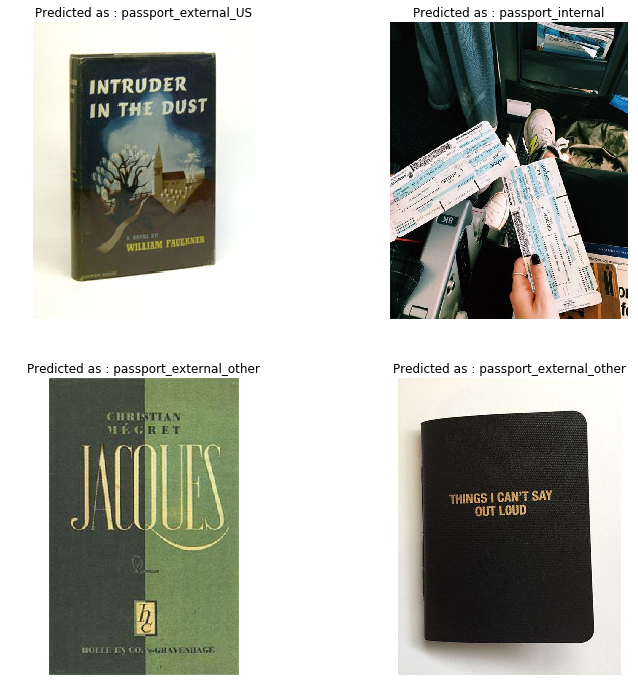

In [42]:
get_wrong_categorization("no_passport", predictions, validation_true)

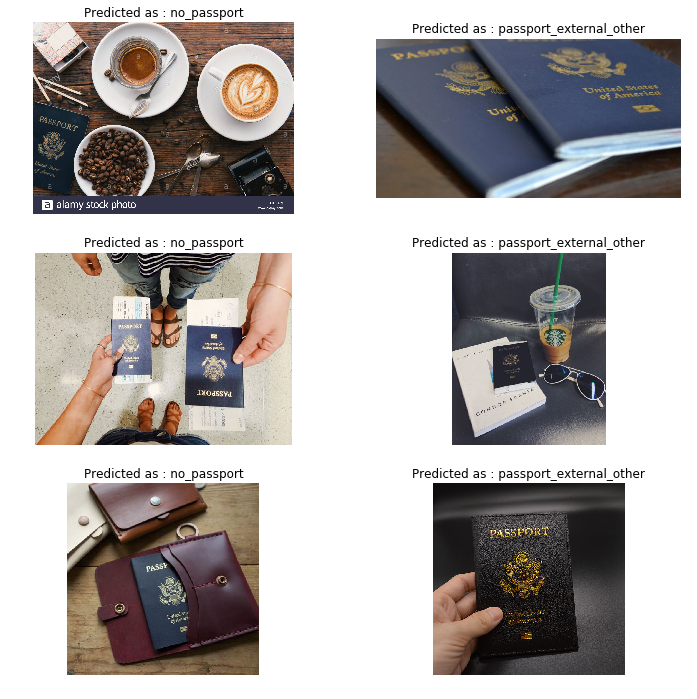

In [45]:
get_wrong_categorization("passport_external_US", predictions, validation_true)

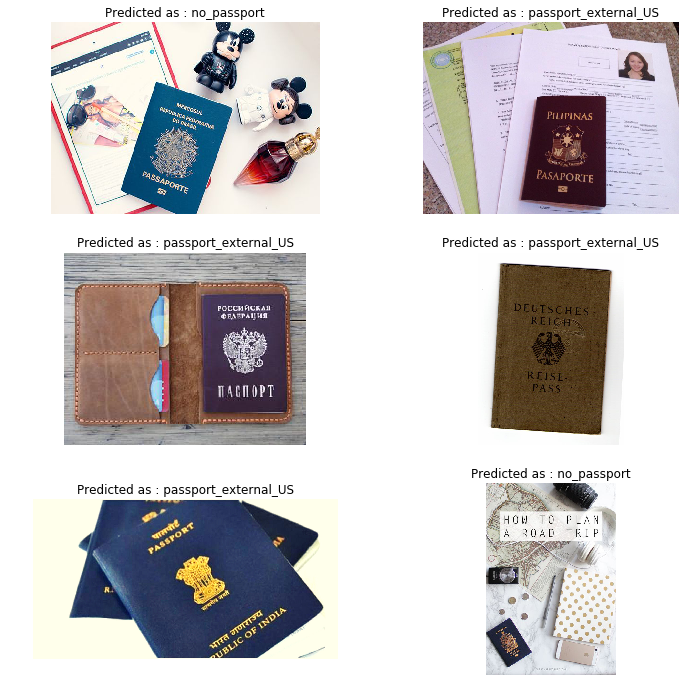

In [50]:
get_wrong_categorization("passport_external_other", predictions, validation_true)

In [20]:
# using a Linear SVM
_ = fit_model(LinearSVC(), resnet_train_X, resnet_training_y, resnet_validation_X, resnet_validation_y)

Classification report from cross validation in training set : 
                         precision    recall  f1-score   support

            no_passport       0.99      0.99      0.99      3004
   passport_external_US       0.96      0.94      0.95       620
passport_external_other       0.96      0.96      0.96      1072
      passport_internal       0.99      0.99      0.99      1304

            avg / total       0.98      0.98      0.98      6000



Classification report for validation set : 
                         precision    recall  f1-score   support

            no_passport       0.94      0.94      0.94       253
   passport_external_US       0.77      0.67      0.72        64
passport_external_other       0.77      0.79      0.78        89
      passport_internal       0.91      0.98      0.94        94

            avg / total       0.88      0.88      0.88       500

